# DoveTools v1.0

Visual theming, easier tag analysis and Otter transcripts for Dovetail

Version 1.0.2, September 2021

### Overview

DoveTools is a collection of tools to complement [Dovetail](https://dovetailapp.com/), the qualitative research platform. Please read the [introductory blog post](https://www.jussipasanen.com/dovetools-visual-theming-tag-analysis-otter-transcripts-for-dovetail) and watch the [video walkthrough](https://youtu.be/Op44Kp8jBOw).

There are currently **three main tools:**

1. Export abbreviated highlights to Miro via Excel, for visual theming and affinity diagramming
2. Analyse tag relationships and see other common tags against the most frequent tags
3. Otter-to-VTT converter that allows importing Otter.ai transcripts into Dovetail

### Instructions

This is a Jupyter Notebook written in Python and hosted on Google Colab.

👉 [Use DoveTools on Google Colab](https://bit.ly/dovetools10)

1. Each cell includes a piece of code
2. You can run a cell by clicking the Play button, or typing Shift+Enter
3. You can see the output of each cell immediately beneath as it is executed
4. Certain cells will prompt you to upload or download files

### Notes

* You need to login to your Google account to run cells. When running the first cell, you will get a prompt saying *Warning: This notebook was not authored by Google*. Once you have reviewed the code, select Run anyway.
* It is not recommended to upload personally identifiable information into the publicly shared version of this notebook. Please create a copy under your own Google profile, or run the notebook locally using a platform like [Anaconda](https://www.anaconda.com/products/individual).

### About this project

This is an open source project hosted on [GitHub](https://github.com/jopas/dovetools) and released under the [MIT license](https://github.com/jopas/dovetools/blob/main/LICENSE). DoveTools has no affiliation to Dovetail.

The example data in this notebook is from a transcript of Steve Krug's [Demo Usability Test](https://www.youtube.com/watch?v=QckIzHC99Xc) (2010), used here with his kind permission.

Reach out to the DoveTools author: [Jussi Pasanen](https://www.jussipasanen.com/contact/) or [@jopas](https://twitter.com/jopas).

## Libraries

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os
import io
import re
import codecs
import textwrap

import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

from ipywidgets import FileUpload
from IPython.display import FileLink, HTML

# show maximum 10 rows in a dataframe
pd.set_option('display.max_rows', 10)

# check if we are running in Google Colab
# see https://stackoverflow.com/a/63519730
in_colab = 'google.colab' in str(get_ipython())

# see https://stackoverflow.com/a/58687620
if in_colab:
    from google.colab import files
    print('Running on Google Colab')
else:
    print('Running locally')    

Running on Google Colab


## File management

In [ ]:
# settings
temp_path = 'temp'

# uploader is created in a function below
uploader = None


# create temporary folder
print(f"Storing temporary files under '{temp_path}' ", end='')
if os.path.isdir(temp_path):
    print('(exists)')
else:
    os.mkdir(temp_path)
    print('(created)')


# see https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#File-Upload
# and https://nikvdp.com/post/jupyter-uploads/
def upload_file(prompt='', accept='.csv'):
    global uploader

    if uploader is None:
        # create uploader
        uploader = FileUpload(accept=accept, multiple=False)
    else:
        uploader.accept = accept
        # reset uploader contents and counter
        uploader.value.clear()
        uploader._counter = 0

    if prompt:
        print(prompt)
    
    display(uploader)


def retrieve_uploaded_file(parse_dataframe=True):
    assert uploader.value, 'No file uploaded'

    # get filename and size
    filename = next(iter(uploader.value))
    size = uploader.value[filename]['metadata']['size']
    print(f'Processing uploaded file: {filename} ({size} bytes)')

    # parse into dataframe or plain text
    content = uploader.value[filename]['content']
    if parse_dataframe:
        return pd.read_csv(io.BytesIO(content))
    else:
        return codecs.decode(content, encoding='utf-8')


# present the input dataframe in a variety of ways
def present_dataframe(df, name, save=False, frmt='xlsx'):
    # NOTE: papyrclip is not available on Google Colab; saving to temporary file instead
    if not save and not in_colab:
        # copy dataframe to clipboard for ready pasting into Excel
        df.to_clipboard(index=False, header=True)

        print(f"The table '{name}' has been copied to clipboard:")
        return

    filename = f'{temp_path}/{name}.{frmt}'

    if frmt == 'csv':
        # save csv to file
        with open(filename, 'w') as f:
            f.write(df.to_csv())

    elif frmt == 'xlsx':
        # save Excel file
        df.to_excel(filename, index=False)

    elif frmt == 'html':
        # save HTML file with inline links
        # a basic link formatter
        formatters = { 'URL': lambda x: f'<a href="{x}">Link</a>' }
        # convert table into HTML with custom link formatter and no escaping
        html = df.to_html(formatters=formatters, index=False, escape=False)
        # add html head and body
        html = f'<!doctype html><html><head><meta charset="UTF-8"></head><body>{html}</body></html>'
        with open(filename, 'w', encoding='utf8') as f:
            f.write(html)

    else:
        print(f'Invalid file format: {frmt}')
        return

    print(f"The table '{name}' has been saved to a temporary {frmt.upper()} file. ", end="")
     
    if in_colab:
        # auto-download on Google Colab
        # see https://stackoverflow.com/a/58687620
        print("Downloading...")
        files.download(filename)
    else:
        print("Download from the link below:")
        display(FileLink(filename))    

Storing temporary files under 'temp' (created)


## Load Dovetail highlights CSV

1. Log in to Dovetail
2. Go to your project
3. Go to Settings (gear icon on the bottom left)
4. Select Export
5. Select Download under 'Export all highlights'
6. Click Upload below to upload the Highlights CSV file from Dovetail

**NOTE**: If the Upload button below is disabled, please go back to the top of this notebook and run each cell (light gray background) in order, then continue running them below. The [example files](https://github.com/jopas/dovetools/tree/main/examples) are available on GitHub.

In [ ]:
upload_file('Please click Upload below to upload a Highlights CSV from Dovetail:')

Please click Upload below to upload a Highlights CSV from Dovetail:


FileUpload(value={}, accept='.csv', description='Upload')

In [ ]:
# load highlights csv
df = retrieve_uploaded_file()

# columns to include, plus Tags
# text, note title and url (default)
columns = ['Text', 'Note - Title', 'URL']

# we only really need text and tag columns
df_filtered = df.filter(columns + ['Tag'])

# Dovetail output is very expansive as each tag is on a separate row, with all the other content duplicated across the data
# - group tags into inline lists against each highlight; see https://stackoverflow.com/a/22221675
df_grouped = df_filtered.groupby(columns)['Tag'].apply(list).reset_index(name='Tags')

# reorder to have URL last
df_grouped = df_grouped.reindex(columns=['Text', 'Note - Title', 'Tags', 'URL'])

# inspect
print("\nA preview of the processed contents:")
df_grouped

Processing uploaded file: Demo Project Highlights.csv (26043 bytes)

A preview of the processed contents:


,Text,Note - Title,Tags,URL
0,guess I would learn how to get a car. I guess...,Session 1 – Demo,"[First impressions, Expectations]",https://dovetailapp.com/projects/b1fbaabd-96f1...
1,"And the, after that it's 1 63, it would be nic...",Session 1 – Demo,"[Suggestion, Improvement, Pain point]",https://dovetailapp.com/projects/b1fbaabd-96f1...
2,And there's an extra value plan when you join ...,Session 1 – Demo,"[Confused, EVP, Comprehension, Pain point]",https://dovetailapp.com/projects/b1fbaabd-96f1...
3,"As you use the site, I'm going to ask you as m...",Session 1 – Demo,"[Instructions, Protocol]",https://dovetailapp.com/projects/b1fbaabd-96f1...
4,Even if the Zipcar right around the corner isn...,Session 1 – Demo,"[Availability, Comprehension]",https://dovetailapp.com/projects/b1fbaabd-96f1...
...,...,...,...,...
17,Zipcar for the iPhone. I have no idea what tha...,Session 1 – Demo,[Confused],https://dovetailapp.com/projects/b1fbaabd-96f1...
18,mostly shopping or looking for information on ...,Session 1 – Demo,[Internet use],https://dovetailapp.com/projects/b1fbaabd-96f1...
19,she was completely stumped by the phrase rates...,Session 1 – Demo,"[Pain point, Plans, Comprehension]",https://dovetailapp.com/projects/b1fbaabd-96f1...
20,that's sometimes my frustration point when I'm...,Session 1 – Demo,"[Trust, Pain point, Costs]",https://dovetailapp.com/projects/b1fbaabd-96f1...


## Export abbreviated highlights to Miro via Excel (xlsx)

Export abbreviated highlights to Miro for more visual theming and affinity diagramming.

* If you arrange your quotes into a **multicolumn structure** in Excel prior to copying, they will be carried over into Miro in a more similar shape.
* Single-column structures typically get pasted into Miro as 3xN note grids.

In [ ]:
# settings
shorten_to = 100

# OPTIONAL: filter down to where a highlight is tagged with a specific set of tags
# tag_set = set(['Pain point', 'Costs'])
tag_set = None


def shorten(text, shorten_to):
    return textwrap.shorten(text, width=shorten_to, placeholder='...')


def note_reference(title):
    reference = title
    for rx_search in [r"(S)(\d+)", r"(P)(\d+)", r"(S)ession (\d+)", r"(P)articipant (\d+)"]:
        match = re.match(rx_search, title)
        if match:
            reference = f'{match[1]}{match[2]}'
            break
    return reference


# create a copy and filter down to tag_set if specified
df_shortened = df_grouped.copy()
if tag_set:
    df_shortened = df_shortened[df_shortened['Tags'].map(tag_set.issubset)]

# add note reference (S1), abbreviate text and convert tag list to string
df_shortened['Text'] = df_shortened.apply(lambda x: f'({note_reference(x["Note - Title"])}) {shorten(x["Text"], shorten_to)}', axis=1)
df_shortened['Tags'] = df_shortened.apply(lambda x: f"{', '.join(x['Tags'])}", axis=1)
df_shortened.rename(columns={'Text': 'Shortened Text'}, inplace=True)

# local: copy dataframe to clipboard for ready pasting into Excel; override by setting save = True
# colab: create temporary file
#save = False  # default
save = True   # override
present_dataframe(df_shortened, 'highlights_abbreviated', save, 'xlsx')
print('Next, open or paste it into Excel, reorganise, then copy and paste into Miro.')

# inspect
df_shortened

The table 'highlights_abbreviated' has been saved to a temporary XLSX file. Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next, open or paste it into Excel, reorganise, then copy and paste into Miro.


,Shortened Text,Note - Title,Tags,URL
0,(S1) guess I would learn how to get a car. I g...,Session 1 – Demo,"First impressions, Expectations",https://dovetailapp.com/projects/b1fbaabd-96f1...
1,"(S1) And the, after that it's 1 63, it would b...",Session 1 – Demo,"Suggestion, Improvement, Pain point",https://dovetailapp.com/projects/b1fbaabd-96f1...
2,(S1) And there's an extra value plan when you ...,Session 1 – Demo,"Confused, EVP, Comprehension, Pain point",https://dovetailapp.com/projects/b1fbaabd-96f1...
3,"(S1) As you use the site, I'm going to ask you...",Session 1 – Demo,"Instructions, Protocol",https://dovetailapp.com/projects/b1fbaabd-96f1...
4,(S1) Even if the Zipcar right around the corne...,Session 1 – Demo,"Availability, Comprehension",https://dovetailapp.com/projects/b1fbaabd-96f1...
...,...,...,...,...
17,(S1) Zipcar for the iPhone. I have no idea wha...,Session 1 – Demo,Confused,https://dovetailapp.com/projects/b1fbaabd-96f1...
18,(S1) mostly shopping or looking for informatio...,Session 1 – Demo,Internet use,https://dovetailapp.com/projects/b1fbaabd-96f1...
19,(S1) she was completely stumped by the phrase ...,Session 1 – Demo,"Pain point, Plans, Comprehension",https://dovetailapp.com/projects/b1fbaabd-96f1...
20,(S1) that's sometimes my frustration point whe...,Session 1 – Demo,"Trust, Pain point, Costs",https://dovetailapp.com/projects/b1fbaabd-96f1...


## Export abbreviated highlights to Miro via Excel (html with clickable links)

Additional processing – convert URLs to inline links.

* Open the generated HTML page, select all, copy and paste into Excel
* It is possible to make entire Shortened Text into a link but that makes Miro notes look unwield due to the excessive underlining

In [ ]:
# NOTE: it is possible to render the table inline using HTML(html)
present_dataframe(df_shortened, 'highlights_abbreviated', save=True, frmt='html')
print('Next, open or paste it into Excel, reorganise, then copy and paste into Miro.')

The table 'highlights_abbreviated' has been saved to a temporary HTML file. Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next, open or paste it into Excel, reorganise, then copy and paste into Miro.


## Count all tags

Count and plot all tags in your project.
* It is generally easier to use the built-in Dovetail **Charts function** for this, unless you need to do some bulk filtering.
* If you have a large project you may need to adjust plot size and filter out some of the long tail.

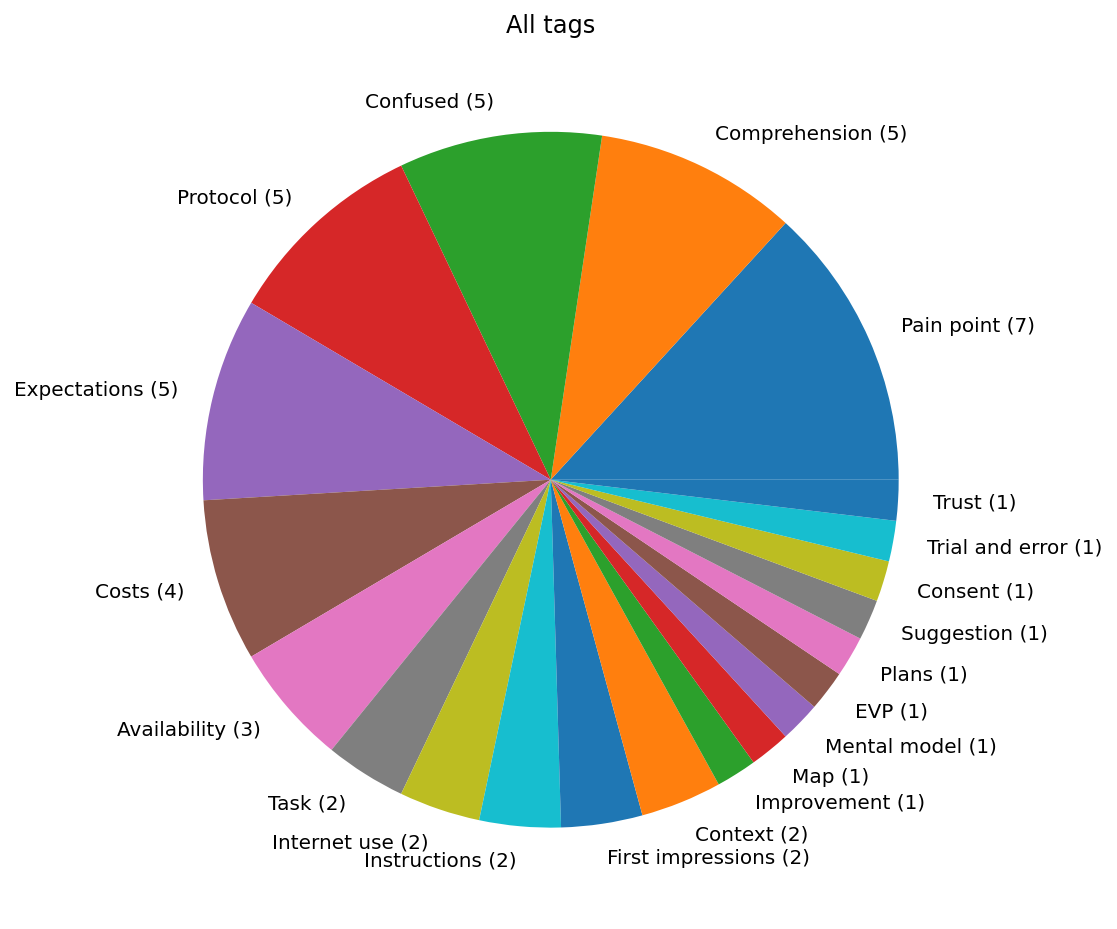

,Count,Tag
Tag,,
Pain point,7,Pain point (7)
Comprehension,5,Comprehension (5)
Confused,5,Confused (5)
Protocol,5,Protocol (5)
Expectations,5,Expectations (5)
...,...,...
Plans,1,Plans (1)
Suggestion,1,Suggestion (1)
Consent,1,Consent (1)


In [ ]:
# reformat counts dataframe
# input:  dataframe with a single column with counts and tag names as index
# output: dataframe 'Count' and 'Tag' columns, with count appended to tag name (1), most frequent tag first
def reformat_counts(counts, add_count_suffix=True):
    # rename first column to Count
    #counts.columns = ['Count']
    counts.rename(columns = { counts.columns[0]: 'Count' }, inplace=True)

    # copy index into a separate column for editing
    counts['Tag'] = counts.index
    
    # add count suffix
    if add_count_suffix:
        counts['Tag'] = counts.agg('{0[Tag]} ({0[Count]})'.format, axis=1)

    # sort by highest count first
    counts.sort_values(by='Count', ascending=False, inplace=True)
    return counts


# filter down to specific columns and reformat counts
df_input   = df_filtered.filter(['Text', 'Tag'])
df_counted = reformat_counts(df_input.groupby('Tag').count())

# plot
plt.figure(figsize=[8,8])
plt.pie(df_counted['Count'], labels=df_counted['Tag'])
plt.title(f'All tags')
plt.show()

# inspect
df_counted

## Count tags related to most common tags

Analyse tag relationships and see other tags that are frequently tagged together with the most common tags.

I find this useful in exploring questions like *'what are the most common pain points'* and *'what works well'*.

6 most common tags: ['Pain point', 'Comprehension', 'Confused', 'Protocol', 'Expectations', 'Costs']
Other tags most commonly tagged with these:


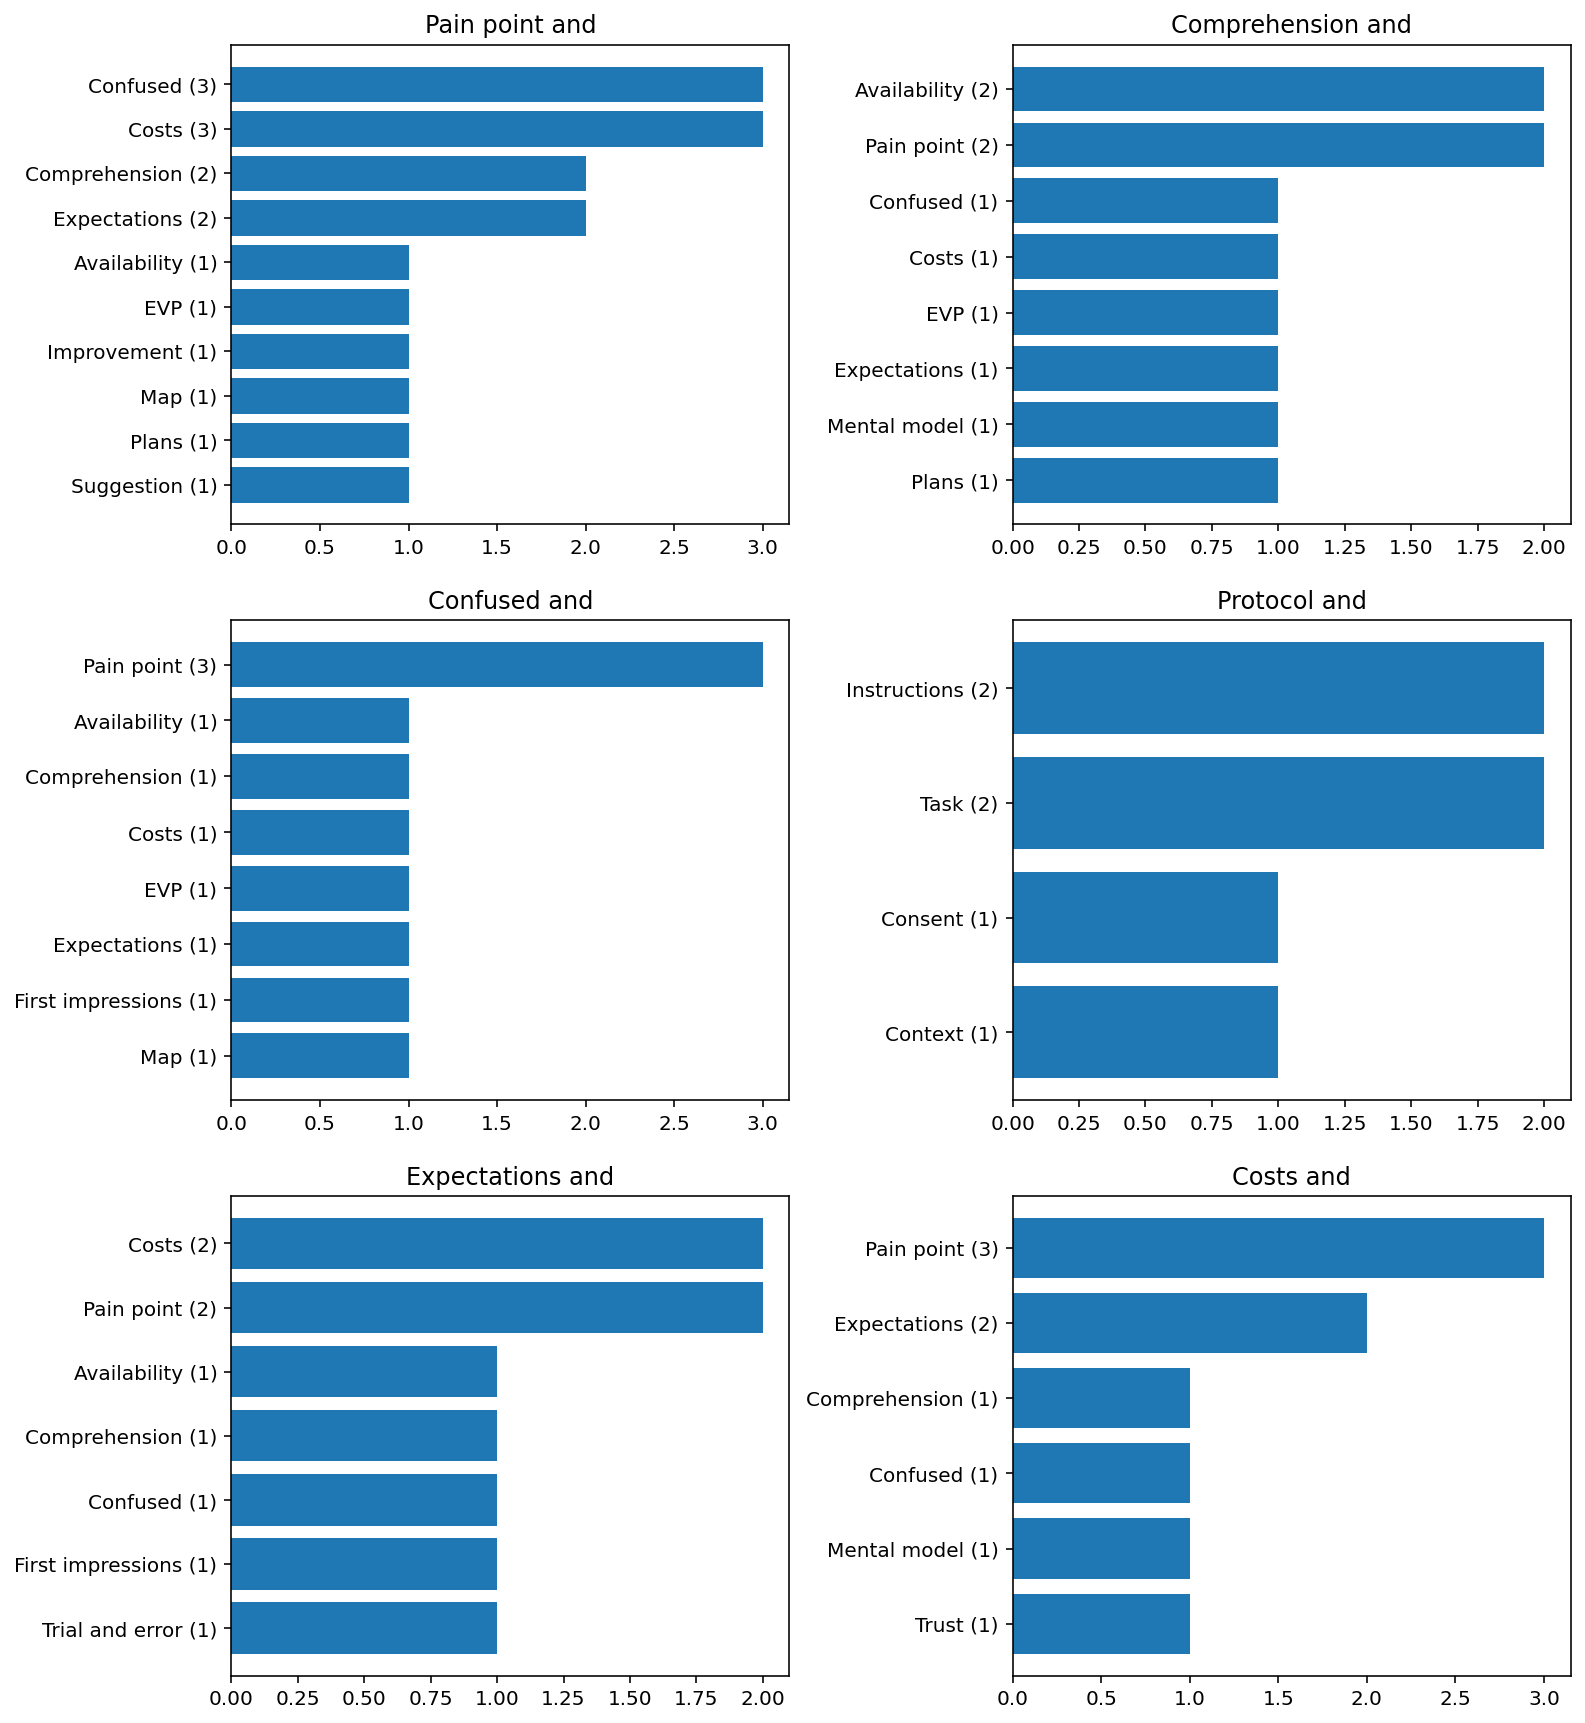

In [ ]:
# settings

# how many most frequent tags to consider
top_tags_count = 6

# how many 'subtags' to consider under each top tag
max_subtags = 10

# subplot columns
columns = 2


def count_related_tags(target_tag):
    # see https://stackoverflow.com/a/41519327
    # NOTE: set/issubset allows filtering against a set, not just a single tag
    #tag_set = set(['Pain point', 'Costs'])
    tag_set = set([target_tag])

    # filter down to where target tag is found in inline list
    subgroups = df_grouped[df_grouped['Tags'].map(tag_set.issubset)]

    # fuse all inline lists into a single flat list
    flattened_tags = subgroups['Tags'].sum()

    # create a dataframe from flat list and use groupby + size to count tag frequencies
    # see https://stackoverflow.com/a/33993693
    counted_tags = pd.DataFrame({'Tag': flattened_tags}).groupby('Tag').size()

    # reformat
    df_subcounted = reformat_counts(pd.DataFrame(counted_tags))

    # target tag is always the most frequent one in the subgroup, drop it from results
    df_subcounted = df_subcounted[df_subcounted.index != target_tag]
    
    return df_subcounted


# get N most frequnt tags
top_tags = df_counted.head(top_tags_count).index
print(f'{top_tags_count} most common tags: {top_tags.to_list()}')
print('Other tags most commonly tagged with these:')

# prepare subplot rows and columns
rows = int(np.ceil(len(top_tags) / columns))
plt.subplots(rows, columns, figsize=[12, rows*5])
plt.subplots_adjust(wspace=0.4)

plotno = 1
for target_tag in top_tags:
    # count related tags against this top tag and trim to max_subtags
    df_subcounted = count_related_tags(target_tag)
    df_subcounted = df_subcounted.head(max_subtags)
    
    # plot
    plt.subplot(rows, columns, plotno)
    plt.barh(df_subcounted['Tag'], df_subcounted['Count'])
    plt.gca().invert_yaxis()
    plt.title(f'{target_tag} and')
    plotno += 1

## Convert Otter transcript to VTT → Dovetail

In [ ]:
# VTT timecode ranges are presented in the following format
# 00:12:06.000 --> 00:13:16.000
def timecode2vtt(timecode):
    timecode_parts = timecode.split(':')
    # add hour part if only minutes and seconds present
    if (len(timecode_parts) < 3):
        timecode_parts.insert(0, '0')
    timecode_parts = ['{:02d}'.format(int(part)) for part in timecode_parts]
    return ':'.join(timecode_parts) + '.000'

    
def process_otter(text):
    # remove empty lines and Otter footer
    lines_to_remove = [ '', 'Transcribed by https://otter.ai' ]
    
    # output dict is easy to convert into a dataframe
    output = dict(
        speaker = [],
        timecode = [],
        transcript = [],
    )    

    # process Otter .txt in 'blocks', separated by a double newline
    for block in text.split('\n\n'):
        lines = block.split('\n')
        lines = [line.strip() for line in lines]

        for line_to_remove in lines_to_remove:
            if line_to_remove in lines:
                lines.remove(line_to_remove)

        line_count = len(lines)

        if line_count == 0:
            # the removed Otter footer generates an empty block
            continue

        elif line_count == 1:
            # additional line(s) of content for an existing speaker and timecode
            transcript = lines[0]
            output['transcript'][-1] += ' ' + transcript

        elif line_count == 2:
            # new block
            speaker, timecode = lines[0].split('  ')
            transcript = lines[1]
            output['speaker'].append(speaker)
            output['timecode'].append(timecode)
            output['transcript'].append(transcript)

        else:
            # safeguard, should not happen
            print(f'Unexpected input format, ignoring ({line_count} lines in a block)')
            continue


    # convert dict to dataframe and shift timecode column forward by 1 to create end timecodes
    df_transcript = pd.DataFrame(output)
    df_transcript['end'] = df_transcript['timecode'].shift(-1)

    # duplicate timecode as end timecode on the very last line
    df_transcript.loc[df_transcript.index[-1], 'end'] = df_transcript.iloc[-1]['timecode']

    # convert timecode and end timecode to VTT format
    df_transcript['timecode'] = df_transcript['timecode'].apply(timecode2vtt)
    df_transcript['end']      = df_transcript['end'].apply(timecode2vtt)

    # add a 'fake' trailing timecode as the bookend for the very last cue
    df_transcript.loc[df_transcript.index[-1], 'end'] = \
        df_transcript.iloc[-1]['timecode'].replace('.000', '.001')

    return df_transcript

In [ ]:
"""
Upload Otter transcript
"""
upload_file('Please click Upload below to upload Otter transcript txt:', '.txt')

Please click Upload below to upload Otter transcript txt:


FileUpload(value={'Demo Project Highlights.csv': {'metadata': {'lastModified': 1630299197495, 'type': 'text/cs…

In [ ]:
"""
Process Otter transcript
"""

# retrieve uploaded text file
text = retrieve_uploaded_file(parse_dataframe=False)

# process and inspect
df_transcript = process_otter(text)
df_transcript    

Processing uploaded file: Demo Usability Test_otter.ai.txt (20910 bytes)


,speaker,timecode,transcript,end
0,Facilitator,00:00:03.000,This is a demo test that I recorded to go alon...,00:03:19.000
1,Participant,00:03:19.000,I am currently unemployed. I volunteer in a ki...,00:03:35.000
2,Facilitator,00:03:35.000,Okay. And what did you do in the Healthcare Ma...,00:03:37.000
3,Participant,00:03:37.000,I work? I managed an admitting office in a hos...,00:03:49.000
4,Facilitator,00:03:49.000,"So you were adults, but it was paediatrics. An...",00:04:50.000
...,...,...,...,...
24,Participant,00:15:46.000,But I'm not seeing anything here in my neighbo...,00:17:37.000
25,Facilitator,00:17:37.000,"Alright, can we try? kalkwasser? Can we go bac...",00:17:58.000
26,Participant,00:17:58.000,I'm going to look at a Zipcar for me. And I'm ...,00:20:18.000
27,Unknown Speaker,00:20:18.000,"Okay, yeah. All right.",00:20:22.000


In [ ]:
"""
Convert processed Otter transcript into downloadable VTT
"""

# settings
#output_file = f'{temp_path}/transcript.vtt'
filename = next(iter(uploader.value)).replace('.txt', '.vtt')
output_file = f'{temp_path}/{filename}'


# output parsed transcript in VTT format
print(f'Writing {output_file}', end='')
with open(output_file, 'w') as f:
    f.write('WEBVTT\n\n')
    for index, row in df_transcript.iterrows():
        #print(row['c1'], row['c2'])
        f.write(f"""{row['timecode']} --> {row['end']}
<v {row['speaker']}>{row['transcript']}</v>

""")

print(', done. ', end='')
if in_colab:
    print("Downloading...")
    files.download(output_file)
else:
    print('Download from the link below:')
    display(FileLink(output_file))

print("""
To upload transcript into Dovetail, click on the three dots ··· under 
your media and select Upload transcript, then upload the VTT file.""")

Writing temp/Demo Usability Test_otter.ai.vtt, done. Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


To upload transcript into Dovetail, click on the three dots ··· under 
your media and select Upload transcript, then upload the VTT file.
